In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
from torch.nn import Parameter

from matplotlib.colors import hsv_to_rgb
import matplotlib.ticker as ticker

In [2]:
# Check if GPU is registered and being used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

devNumber = torch.cuda.current_device()
print(f"The current device number is {devNumber}")

dev_name = torch.cuda.get_device_name(devNumber)
print(f"GPU is {dev_name}")

Using Device: cuda
The current device number is 0
GPU is NVIDIA GeForce RTX 2060


### Global Variables

In [3]:
pix_size = 1e-5 #[m]
grid_size = 500 # Number of pixels per side of the grid
grid_length = pix_size * grid_size # Length of grid in real space coords
wl = 700e-9 #[m]
distance = 0.1 # Total distance travelled by the field

### Functions

In [4]:
# Useful functions not directly related to the workings of the model

def Complex2HSV(z, rmin, rmax, hue_start=90):
    # get amplidude of z and limit to [rmin, rmax]
    amp = np.abs(z)
    amp = np.where(amp < rmin, rmin, amp)
    amp = np.where(amp > rmax, rmax, amp)
    ph = np.angle(z, deg=1)# + hue_start
    # HSV are values in range [0,1]
    h = (ph % 360) / 360
    s = 0.85 * np.ones_like(h)
    v = (amp -rmin) / (rmax - rmin)
    return hsv_to_rgb(np.dstack((h,s,v)))

def gaussian(A, sigma, shape, mux=0, muy=0, warpx=0,warpy=0, B=0):
    """Makes a gaussian tensor of size = shape*shape. Intensity = A. Half-width = sigma. 
    Off-centre with 'mux' and 'muy' (-1 to +1). Or warp the shape with 'warpx' and 'warpy'."""
    X, Y = np.meshgrid(np.linspace((-1-mux)*(1+warpy), (1-mux)*(1+warpy), shape), np.linspace((-1+muy)*(1+warpx), (1+muy)*(1+warpx), shape))
    Z = (X**2 + Y**2)**0.5
    gauss = A * np.exp(-(Z**2)/(2*sigma**2)) + B
    return torch.from_numpy(gauss)

def loss_fn(output, target):
    return (output.abs().square() - target.abs().square()).abs().sum()

def loss_func(outputs, targets):
    """Loss function for multiple sets of training data."""
    loss = 0
    for i in range(len(outputs)):
        loss += (outputs[i].abs().square() - targets[i].abs().square()).abs().sum()
    loss /= len(outputs)
    return loss

In [5]:
# Functions directly related to getting variable for the model

def find_kz():
    """Generates a kz array for free space propagation."""
    Nx = np.arange(-grid_size/2,grid_size/2,1)
    Ny = np.arange(-grid_size/2,grid_size/2,1)
    X,Y = np.meshgrid(Nx,Ny)
    X = torch.from_numpy(X)
    Y = torch.from_numpy(Y)

    # Make the Kx, Ky and Kz grids.
    # Start with making arrays of the right size to append correct values onto later.
    Kx = np.ones((grid_size,grid_size))
    Ky = np.ones((grid_size,grid_size))

    for y,i in zip(np.arange(-grid_size/2,grid_size/2,1), np.arange(0,grid_size+1,1)):
        for x,j in zip(np.arange(-grid_size/2,grid_size/2,1), np.arange(0,grid_size+1,1)):
            Kx[i,j] = (2*np.pi*x)/grid_length
            Ky[i,j] = (2*np.pi*y)/grid_length
    
    Kz = torch.from_numpy(((2*np.pi/wl)**2 - Kx**2 - Ky**2)**0.5)
    return Kz

# Make FFT functions
def fft2(field: torch.Tensor) -> torch.Tensor:
    """2D discrete forward fourier transform."""
    return torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(field)))

def ifft2(field: torch.Tensor) -> torch.Tensor:
    """2D discrete inverse fourier transform."""
    return torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(field)))

# Make a propagation function using these fft2 functions that works on GPU
def prop(field_in, kz, distance):
    """Propagation of a 2D field using the fft2 functions."""
    field_in_ft = fft2(field_in).to(device)
    field_out_ft = field_in_ft * torch.exp(1j*kz.to(device)*distance)
    field_out = ifft2(field_out_ft)
    return field_out

# Construct a Frenel Lens
def frenel_lens_mask(X:torch.Tensor, Y:torch.Tensor,wl:float, f:float=0.1):
    """frenel lens phase mask"""
    lens_phase = (2*np.pi/wl) * (f - (X**2 + Y**2 + f**2)**0.5)
    return torch.exp(1j*lens_phase)

def frenel2d(field_in:torch.Tensor, wl:float, f:float=0.1):
    """Apply frenel lens phase mask onto a 2D input field."""
    Nx = np.arange(-grid_size/2,grid_size/2,1)
    Ny = np.arange(-grid_size/2,grid_size/2,1)
    X,Y = np.meshgrid(Nx,Ny)
    X = torch.from_numpy(X)*pix_size
    Y = torch.from_numpy(Y)*pix_size

    lens_phase = (2*np.pi/wl) * (f - (X**2 + Y**2 + f**2)**0.5)
    field_out = field_in * torch.exp(1j*lens_phase.to(device))
    return field_out

def frenel_forward(field_in, kz, z1, dist, f, wl=700e-9):
    field_before_mask = prop(field_in, kz, z1)
    field_after_mask = frenel2d(field_before_mask, wl, f)
    target_field = prop(field_after_mask, kz, (dist-z1))

    return target_field

In [6]:
class Field(torch.Tensor):
    """Class designed around a 2D electric field represented by a torch tensor."""
    wl = 700e-9 #[m]
    k = torch.tensor(2*np.pi/wl) #[1/m]
    k_x = 1235678
    k_y = 3457437
    k_z = (torch.abs(k)**2 - k_x**2 - k_y**2)**0.5 #[1/m]
    
    def __init__(self, tensor):
        self = tensor

    def normalise(self):
        return self / torch.linalg.matrix_norm(self)

    def visualise(self, figsize=(10,5),title=""):
        """Displays a visual plot of the field, using hsv colour mapping to demonstrate the 
        fields phase (Hue) and amplitude (Value)."""
        # Set up plots
        fig, axs = plt.subplots(1,2, figsize=figsize)

        # Plot the given field
        axs[0].imshow(Complex2HSV(self, 0, 0.025))

        # Colour bar
        V, H = np.mgrid[0:1:100j, 0:1:300j]
        S = np.ones_like(V)
        HSV = np.dstack((H,S,V))
        RGB = hsv_to_rgb(HSV)

        axs[1].imshow(RGB, origin="lower", extent=[0, 2*np.pi, 0, 1], aspect=15)

        axs[1].set_xticks([0, np.pi, 2*np.pi], ['0', '$\pi$', '$2\pi$'])
        axs[1].set_yticks([0, 1], ['0', '1'])

        axs[1].set_ylabel("Amplitude")
        axs[1].set_xlabel("Phase (rad.)")

        fig.show()

### Model

In [7]:
class FrenelModel(nn.Module):

    def __init__(self, distance=0.1, grid_size=500, z1=0.03, wl=700e-9):
        super(FrenelModel,self).__init__()
        self.wl = wl # Wavelength
        #self.f = f # Focal length of the frenel lens
        self.distance = distance # Total length travelled by field (z1 + z2)
        self.grid_size = grid_size # Number of pixels per side of the grid
        self.grid_length = pix_size * grid_size # Length of grid in real space coords
        self.Kz = find_kz()
        # Parameters
        self.z1 = nn.Parameter(data=torch.tensor([z1], dtype=torch.float32, requires_grad=True))

    def forward(self, input_field, f):
        field_before_mask = prop(input_field, self.Kz, self.z1)
        field_after_mask = frenel2d(field_before_mask, self.wl, f)
        output_field = prop(field_after_mask, self.Kz, (self.distance-self.z1))
        return output_field

### Code

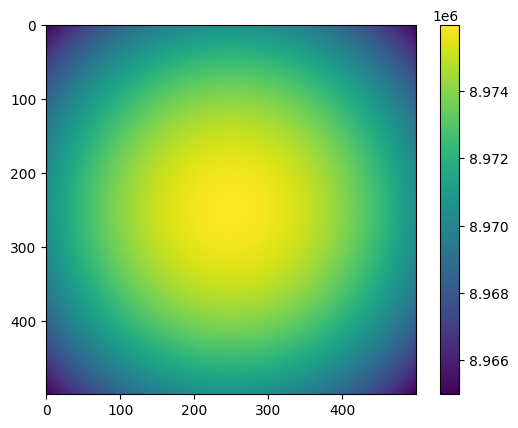

In [8]:
Nx = np.arange(-grid_size/2,grid_size/2,1)
Ny = np.arange(-grid_size/2,grid_size/2,1)
X,Y = np.meshgrid(Nx,Ny)
X = torch.from_numpy(X)
Y = torch.from_numpy(Y)

kz_visual = find_kz()
kz = kz_visual.to(device)
plt.imshow(kz_visual)
plt.colorbar()

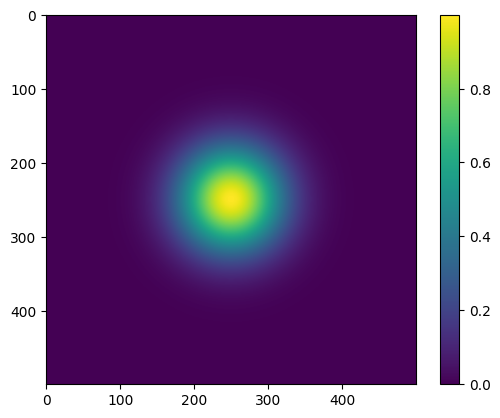

In [9]:
gauss_field = gaussian(1,0.2,500)
plt.imshow(gauss_field)
plt.colorbar()

input_field = gauss_field.to(device)

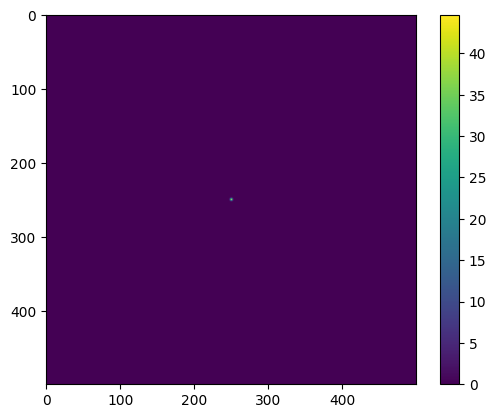

In [10]:
target_field = frenel_forward(input_field, kz, 0.05, 0.1, 0.05)
plt.imshow(abs(target_field).cpu().numpy())
plt.colorbar()

Epoch 0, Loss: 15336.479134344805, z1: 0.03009999915957451, z2: 0.0699000008404255
Epoch 100, Loss: 13541.091936397353, z1: 0.043831951916217804, z2: 0.0561680480837822
Epoch 200, Loss: 2.0574765146182328, z1: 0.0499860905110836, z2: 0.0500139094889164
Epoch 300, Loss: 0.05113703602138163, z1: 0.05000102147459984, z2: 0.04999897852540017
Epoch 400, Loss: 0.09142341685522165, z1: 0.04999867081642151, z2: 0.0500013291835785
Epoch 500, Loss: 0.20053287799198305, z1: 0.050001032650470734, z2: 0.04999896734952927
Epoch 600, Loss: 0.08741058792265223, z1: 0.05000149458646774, z2: 0.04999850541353226
Epoch 700, Loss: 0.14162212818660078, z1: 0.04999799653887749, z2: 0.05000200346112252
Epoch 800, Loss: 0.27501968956787237, z1: 0.0500013642013073, z2: 0.04999863579869271
Epoch 900, Loss: 0.12371654767618151, z1: 0.050001952797174454, z2: 0.04999804720282555
Final Loss: 0.1690132019285265
Final z1: 0.0499982126057148
Final z2: 0.05000178739428521


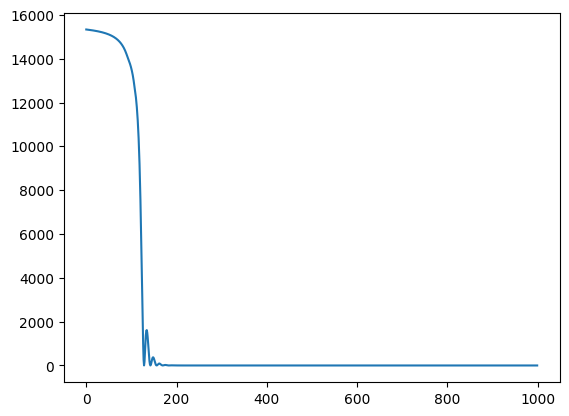

In [14]:
# Training Loop
model = FrenelModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 1000
epoch_list = []
loss_list = []

for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(input_field, f=0.05)

    loss = loss_fn(y_pred, target_field)
    loss.backward()
    optimizer.step()

    epoch_list.append(epoch)
    loss_list.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, z1: {model.z1.item()}, z2: {0.1 - model.z1.item()}")

print(f"Final Loss: {loss.item()}")
print(f"Final z1: {model.z1.item()}")
print(f"Final z2: {0.1 - model.z1.item()}")

plt.plot(epoch_list, loss_list)

In [12]:
def plot_loss_function(input_field) -> None:
    # Plot the loss as a function of distance comparing the two models
    dists = []
    losses = []
    for a in range(200, 800):
        # Create a new model with a different distance each itteration.
        new_model = FrenelModel(torch.tensor([a/10000]), phase_mask).to(device)
        out_fields = new_model(input_field)
        # Give the model a set of phase masks and find its output.
        loss = loss_fn(out_fields, real_out).cpu().detach().numpy()
        losses.append(loss)
        dists.append(a/10000)
    # Plot the loss function.
    ax = plt.subplot()
    ax.plot(dists, losses)
    ax.set_xlabel("Distance")
    ax.set_ylabel("Loss")
    ax.legend()

In [13]:
loss = []
xs = torch.from_numpy(np.linspace(0.04,0.06,500))
target = frenel_forward(input_field, kz, 0.05, 0.1, 0.05)
for i in range(xs.size()[0]):
    model = FrenelModel(z1=xs[i]).to(device)
    #print(next(model.parameters()).is_cuda)
    y_pred = model(input_field)
    #print(f"Target: {target.is_cuda}")
    loss.append(loss_fn(y_pred, target).cpu().detach().numpy())
    if i % 100 == 0:
        print(i)

plt.plot(xs,loss)

TypeError: FrenelModel.forward() missing 1 required positional argument: 'f'

In [ ]:
def rand_focus(batch: int=10) -> list:
    """Generates 'batch' number of focal lengths."""
    focus = []
    for _ in range(batch):
        focus.append(random.randrange(5, 100)/1000)
    return focus

# Generate training data
batch = 50
fs = rand_focus(batch)

# Input gaussian beam
field_in = Field(gaussian(1, 0.2, 500)).normalise().to(device)

# Make target data
targets = []
for i in range(batch):
    targets.append(frenel_forward(field_in, kz, 0.05, 0.1, f=fs[i]))

In [ ]:
fs

[0.055,
 0.077,
 0.04,
 0.016,
 0.072,
 0.052,
 0.094,
 0.053,
 0.095,
 0.026,
 0.056,
 0.02,
 0.097,
 0.01,
 0.031,
 0.099,
 0.053,
 0.053,
 0.023,
 0.076,
 0.08,
 0.041,
 0.046,
 0.077,
 0.012,
 0.018,
 0.081,
 0.06,
 0.036,
 0.078,
 0.037,
 0.039,
 0.018,
 0.022,
 0.078,
 0.065,
 0.01,
 0.045,
 0.019,
 0.012,
 0.063,
 0.05,
 0.074,
 0.011,
 0.097,
 0.033,
 0.086,
 0.014,
 0.036,
 0.092]

In [ ]:
# Training Loop
model = FrenelModel().to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 1000

for epoch in range(epochs):
    optimiser.zero_grad()
    fields_out = []
    for i in range(batch):
        fields_out.append(model(field_in, f=fs[i]))
    loss = loss_func(fields_out, targets)
    loss.backward()
    optimiser.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, z1: {model.z1.item()}, z2: {0.3 - model.z1.item()}")

print(f"Final Loss: {loss.item()}")
print(f"Final z1: {model.z1.item()}")
print(f"Final z2: {0.3 - model.z1.item()}")

Epoch 0, Loss: 1.1652707225918197, z1: 0.03009999915957451, z2: 0.2699000008404255
Epoch 100, Loss: 0.7162620728282038, z1: 0.0412989966571331, z2: 0.2587010033428669
Epoch 200, Loss: 0.00685927758024184, z1: 0.050009358674287796, z2: 0.2499906413257122
Epoch 300, Loss: 0.0027072088897806086, z1: 0.050005462020635605, z2: 0.24999453797936438
Epoch 400, Loss: 0.0014592933399156397, z1: 0.04997989162802696, z2: 0.250020108371973
Epoch 500, Loss: 0.0008875956654313142, z1: 0.049981918185949326, z2: 0.25001808181405066
Epoch 600, Loss: 0.00017678504643698002, z1: 0.049982983618974686, z2: 0.2500170163810253
Epoch 700, Loss: 0.00010979242284271446, z1: 0.04998479783535004, z2: 0.25001520216464995
Epoch 800, Loss: 0.004581114422116126, z1: 0.04999304935336113, z2: 0.25000695064663886
Epoch 900, Loss: 0.0005157204571454144, z1: 0.049990344792604446, z2: 0.25000965520739554
Final Loss: 0.0012436732982902654
Final z1: 0.049996037036180496
Final z2: 0.2500039629638195


0
100
200
300
400


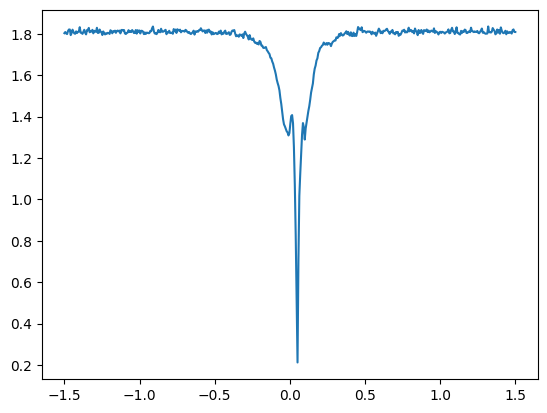

In [ ]:
loss = []
xs = torch.from_numpy(np.linspace(-1.5,1.5,500))

for i in range(xs.size()[0]):
    model = FrenelModel(z1=xs[i]).to(device)
    fields_out = []
    if i % 100 == 0:
        print(i)
    for j in range(batch):
        fields_out.append(model(field_in, fs[j]))
    loss.append(loss_func(fields_out, targets).cpu().detach().numpy())

plt.plot(xs,loss)